#📌 Extracão

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import json

url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
response = requests.get(url)
data = response.json()
df = pd.json_normalize(data)

#🔧 Transformação

###Durante a preparação dos dados, foram realizadas as seguintes etapas:
Importação do dataset em um DataFrame Pandas.

Verificação de valores ausentes e consistência dos tipos de dados.

Conversão de colunas binárias (Yes/No) para valores numéricos 0/1 (como customer.Partner, customer.Dependents, etc.).

Garantia de que a coluna Churn estava no formato int64 para facilitar cálculos.

Renomeação de variáveis e rótulos para melhor leitura dos gráficos (ex: tradução de Male para Masculino).

In [33]:
# Eu transformei as colunas que tem apenas yes/no em Int64.
# Pesquisei antes se é uma boa alternativa e aparentemente é
# muito melhor fazer isso pra colunas assim.
def convert_to_int(df):
  for col in df.columns:
    if df[col].dropna().isin(['Yes', 'No', ' yes', ' no', 'YES', 'NO', '']).all():
      df[col] = df[col].astype(str).str.strip().str.capitalize()
      df[col] = df[col].replace('', np.nan)
      df[col] = df[col].map({'No': 0, 'Yes': 1})
      df[col] = df[col].astype('Int64')
  return df

cols = ['internet.InternetService', 'account.Contract', 'account.PaymentMethod']
def categorizar_coluna(df):
  resultado = []
  for col in cols:
    resultado.append(f'Categorias da coluna "{col}": {", ".join(map(str, df[col].unique()))}')
  return '\n'.join(resultado)


print(categorizar_coluna(df))
df = convert_to_int(df)

# converti a coluna em float64
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')
# retirei da coluna churn os valores vazios
df = df[df['Churn'] != '']
# preenchi com o valor 0 os nan desta coluna pois sao clientes novos que
# nao tem cobrança total ainda
df['account.Charges.Total'] = df['account.Charges.Total'].fillna(0)
# como solicitado no trello, adicionei uma coluna nova de cobranças diarias
df['account.Charges.Daily'] = round(df['account.Charges.Monthly'] / (365/12), 2)

# Dicionário de dados

# customerID: número de identificação único de cada cliente
# Churn: se o cliente deixou ou não a empresa
# gender: gênero (masculino e feminino)
# SeniorCitizen: informação sobre um cliente ter ou não idade igual ou maior que 65 anos
# Partner: se o cliente possui ou não um parceiro ou parceira
# Dependents: se o cliente possui ou não dependentes
# tenure: meses de contrato do cliente
# PhoneService: assinatura de serviço telefônico
# MultipleLines: assisnatura de mais de uma linha de telefone
# InternetService: assinatura de um provedor internet
# OnlineSecurity: assinatura adicional de segurança online
# OnlineBackup: assinatura adicional de backup online
# DeviceProtection: assinatura adicional de proteção no dispositivo
# TechSupport: assinatura adicional de suporte técnico, menos tempo de espera
# StreamingTV: assinatura de TV a cabo
# StreamingMovies: assinatura de streaming de filmes
# Contract: tipo de contrato
# PaperlessBilling: se o cliente prefere receber online a fatura
# PaymentMethod: forma de pagamento
# Charges.Monthly: total de todos os serviços do cliente por mês
# Charges.Total: total gasto pelo cliente

Categorias da coluna "internet.InternetService": DSL, Fiber optic, No
Categorias da coluna "account.Contract": One year, Month-to-month, Two year
Categorias da coluna "account.PaymentMethod": Mailed check, Electronic check, Credit card (automatic), Bank transfer (automatic)


#📊 Carga e análise

A evasão de clientes (ou churn) é um dos principais desafios enfrentados por empresas de serviços recorrentes, como telecomunicações e bancos. Identificar quem são os clientes com maior propensão a cancelar o serviço permite adotar estratégias mais assertivas de retenção.

Neste projeto, o objetivo foi analisar o comportamento dos clientes com base em um conjunto de dados estruturado e descobrir quais fatores estão associados à evasão.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   Int64  
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   int64  
 4   customer.Partner           7043 non-null   Int64  
 5   customer.Dependents        7043 non-null   Int64  
 6   customer.tenure            7043 non-null   int64  
 7   phone.PhoneService         7043 non-null   Int64  
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   object 
 1

Agrupando o DataFrame pela coluna Churn e calculando a média, mediana, desvio padrão, mínimo e máximo pra Tempo de contrato, Cobrança Total e Cobrança mensal.

In [34]:
def resumo_estatistico_por_churn(colunas, df):
    return df.groupby('Churn')[colunas].agg(['mean', 'median', 'std', 'min', 'max'])
resumo_estatistico_por_churn(
    ['customer.tenure', 'account.Charges.Total', 'account.Charges.Monthly'],
    df
)

customer.tenure                           account.Charges.Total  \
                 mean median        std min max                  mean   
Churn                                                                   
0           37.569965   38.0  24.113777   0  72           2549.911442   
1           17.979133   10.0  19.531123   1  72           1531.796094   

                                             account.Charges.Monthly          \
         median          std    min      max                    mean  median   
Churn                                                                          
0      1679.525  2329.954215   0.00  8672.45               61.265124  64.425   
1       703.550  1890.822994  18.85  8684.80               74.441332  79.650   

                                 
             std    min     max  
Churn                            
0      31.092648  18.25  118.75  
1      24.666053  18.85  118.35

In [62]:
qtd_clients = df['Churn'].count()
qtd_churn = df['Churn'].sum()
qtd_no_churn = qtd_clients - qtd_churn
print(f'Total de clientes: {qtd_clients}')
print(f'São {qtd_no_churn} clientes que continuam. Representando: {((qtd_no_churn/qtd_clients) * 100):.2f}%')
print(f'e {qtd_churn} clientes que cancelaram. Representando: {((qtd_churn/qtd_clients) * 100):.2f}%')

Total de clientes: 7043
São 5174 clientes que continuam. Representando: 73.46%
e 1869 clientes que cancelaram. Representando: 26.54%


In [63]:
print(f'A média de meses de contrato é de {df["customer.tenure"].mean():.0f}.')
print(f"Já a mediana é {df['customer.tenure'].median():.0f}.")

A média de meses de contrato é de 32.
Já a mediana é 29.


In [37]:
print(f"A média de gasto por cliente é:")
prazos = {'Diário': df["account.Charges.Daily"], 'Mensal': df["account.Charges.Monthly"], 'Total': df["account.Charges.Total"]}
for prazo, serie in prazos.items():
  print(f"{prazo}: R$ {serie.mean():.2f}")

A média de gasto por cliente é:
Diário: R$ 2.13
Mensal: R$ 64.76
Total: R$ 2279.73


In [65]:
pay_counts =  df['account.PaymentMethod'].value_counts(ascending=True)
print('Métodos de pagamento:')
for metodo, valor in pay_counts.items():
  print(f'{metodo}: {valor} clientes')

Métodos de pagamento:
Credit card (automatic): 1522 clientes
Bank transfer (automatic): 1544 clientes
Mailed check: 1612 clientes
Electronic check: 2365 clientes


In [68]:
churn_por_sexo = (df.groupby('customer.gender')['Churn'].mean()*100)
churn_por_sexo = churn_por_sexo.rename(index={'Female': 'Feminino', 'Male': 'Masculino'})
print('Taxa de Churn por Sexo:')
for sexo, taxa in churn_por_sexo.items():
  print(f'{sexo}: {taxa:.2f}%')
churn_sexo = df.groupby('customer.gender')['Churn'].sum()
churn_sexo = churn_sexo.rename(index={'Female': 'Feminino', 'Male': 'Masculino'})
print()
churn_sexo

Taxa de Churn por Sexo:
Feminino: 26.92%
Masculino: 26.16%



,Churn
customer.gender,
Feminino,939
Masculino,930


In [69]:
churn_por_senior = (df.groupby('customer.SeniorCitizen')['Churn'].mean() * 100)
churn_por_senior = churn_por_senior.rename(index={0: 'Não idosos', 1: 'Idosos'})
print("Taxa de Churn por Idade:")
for idade, taxa in churn_por_senior.items():
  print(f'{idade}: {taxa:.2f}%')

Taxa de Churn por Idade:
Não idosos: 23.61%
Idosos: 41.68%


/tmp/ipython-input-70-1113489484.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x='Churn', data=df, palette='pastel')
/tmp/ipython-input-70-1113489484.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Ficaram', 'Saíram'])


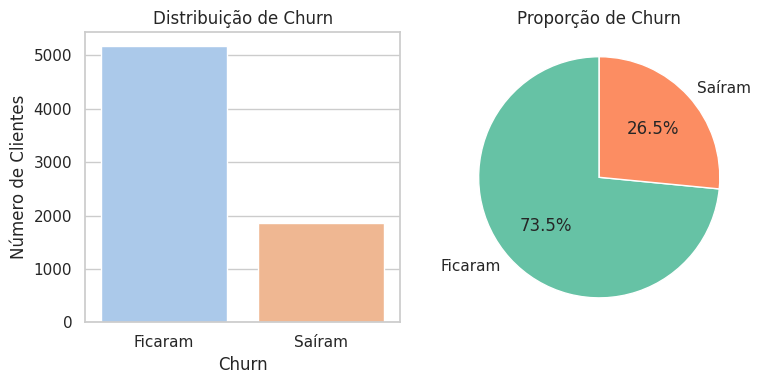

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
churn_counts = df['Churn'].value_counts()
labels = ['Ficaram', 'Saíram']
colors = ['#66c2a5', '#fc8d62']
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.countplot(ax=axes[0], x='Churn', data=df, palette='pastel')
axes[0].set_xticklabels(['Ficaram', 'Saíram'])
axes[0].set_title('Distribuição de Churn')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Número de Clientes')
axes[1].pie(churn_counts, labels=labels, autopct='%1.1f%%',
            startangle=90, colors=colors)
axes[1].set_title('Proporção de Churn')
axes[1].axis('equal')

plt.tight_layout()
plt.show()


###Investigando como a evasão (churn) se relaciona com variáveis categóricas como:

Sexo, Tipo de contrato, Método de pagamento, Possui dependentes e Serviços ativos

### Objetivo:

Analisar se certos perfis de clientes apresentam maior taxa de churn, com gráficos comparativos e porcentagens para facilitar a interpretação estratégica.

In [72]:
def plot_stacked_churn(coluna, df):
    import matplotlib.pyplot as plt

    prop = df.groupby(coluna)['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
    prop.columns = ['Ficaram', 'Saíram']
    prop = prop.sort_values('Saíram', ascending=True)
    prop.plot(kind='barh', stacked=True, figsize=(7, 4), color=['#66c2a5', '#fc8d62'])
    plt.title(f'Proporção de Churn por {coluna}')
    plt.xlabel('Percentual (%)')
    plt.legend(loc='upper center')
    plt.tight_layout()
    plt.show()

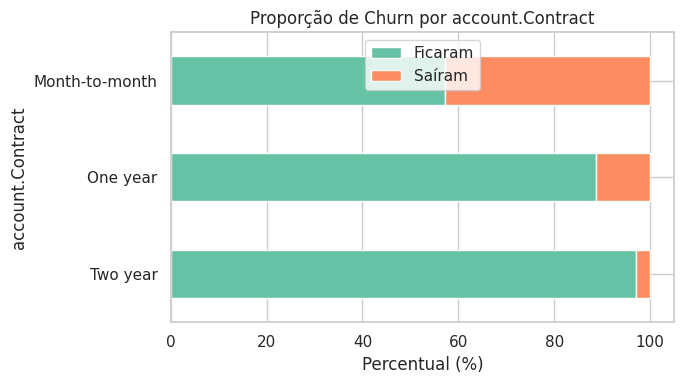

In [73]:
plot_stacked_churn('account.Contract', df)

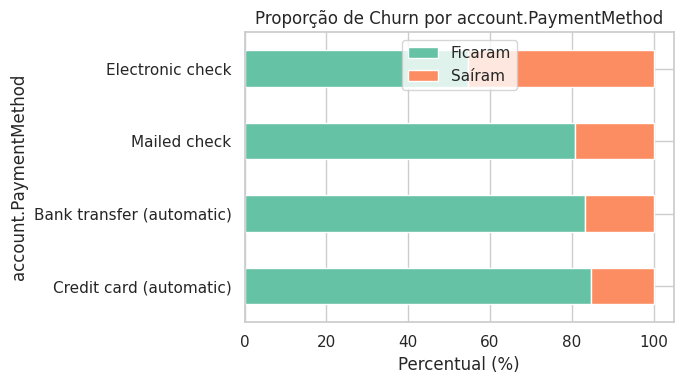

In [44]:
plot_stacked_churn('account.PaymentMethod', df)

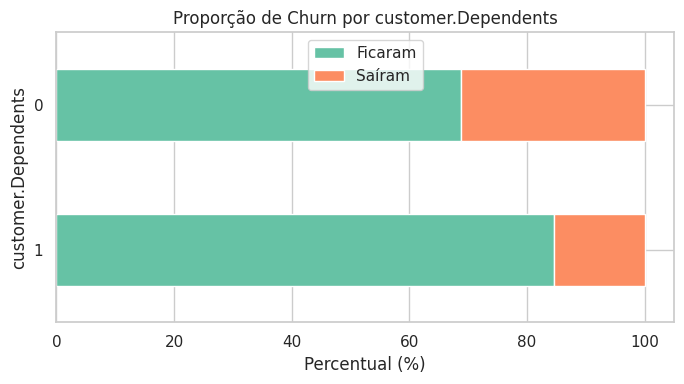

In [45]:
plot_stacked_churn('customer.Dependents', df)

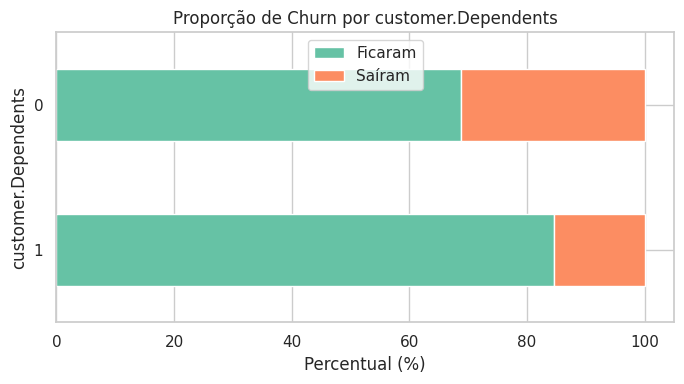

In [46]:
plot_stacked_churn('customer.Dependents', df)

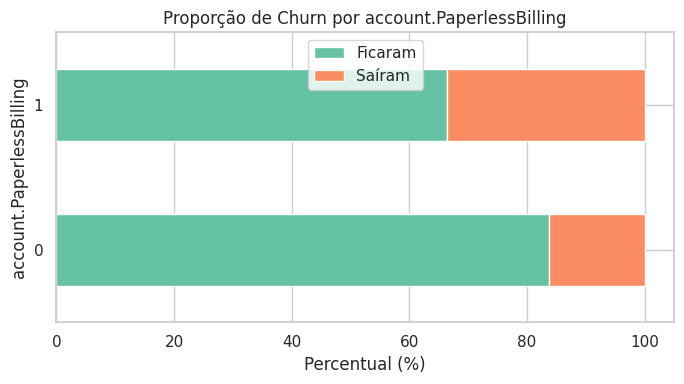

In [47]:
plot_stacked_churn('account.PaperlessBilling', df)

### Analisando como essas variáveis se distribuem separadamente entre os clientes que cancelaram e os que permaneceram:


In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_box_by_churn(coluna, df):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Churn', y=coluna, data=df, palette='Set2')
    plt.title(f'{coluna} por Churn (0 = Ficaram, 1 = Saíram)')
    plt.xlabel('Churn')
    plt.ylabel(coluna)
    plt.tight_layout()
    plt.show()
def plot_dist_by_churn(coluna, df):
    plt.figure(figsize=(7, 5))
    sns.histplot(data=df, x=coluna, hue='Churn', kde=True, stat='density', palette='Set1', common_norm=False)
    plt.title(f'Distribuição de {coluna} por Churn')
    plt.xlabel(coluna)
    plt.ylabel('Densidade')
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-74-1383166084.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=coluna, data=df, palette='Set2')


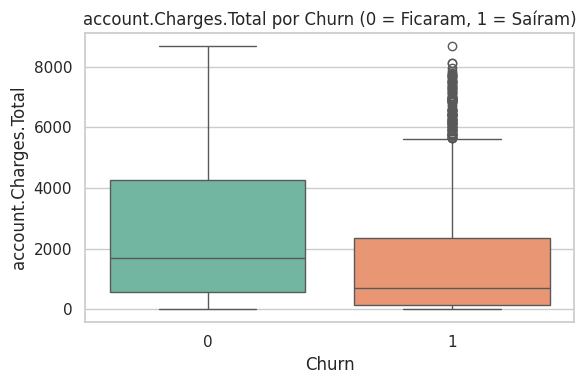

In [75]:
plot_box_by_churn('account.Charges.Total', df)

/tmp/ipython-input-74-1383166084.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=coluna, data=df, palette='Set2')


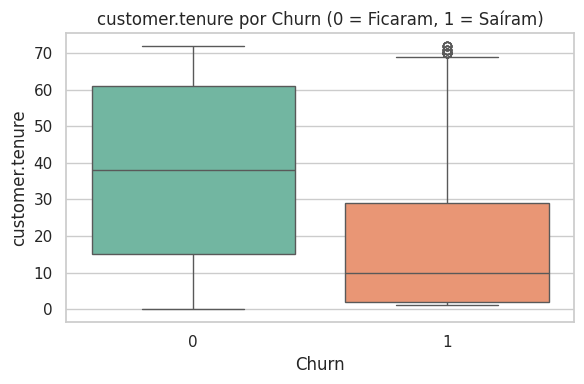

In [76]:
plot_box_by_churn('customer.tenure', df)

/tmp/ipython-input-74-1383166084.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=coluna, data=df, palette='Set2')


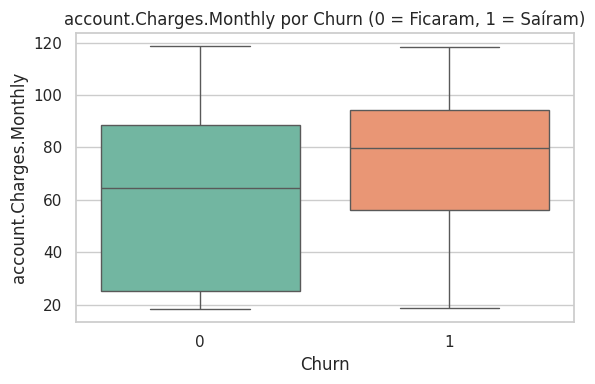

In [77]:
plot_box_by_churn('account.Charges.Monthly', df)

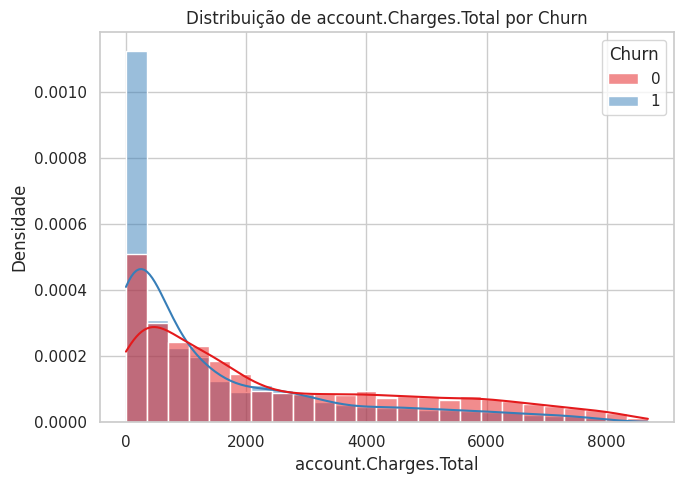

In [52]:
plot_dist_by_churn('account.Charges.Total', df)

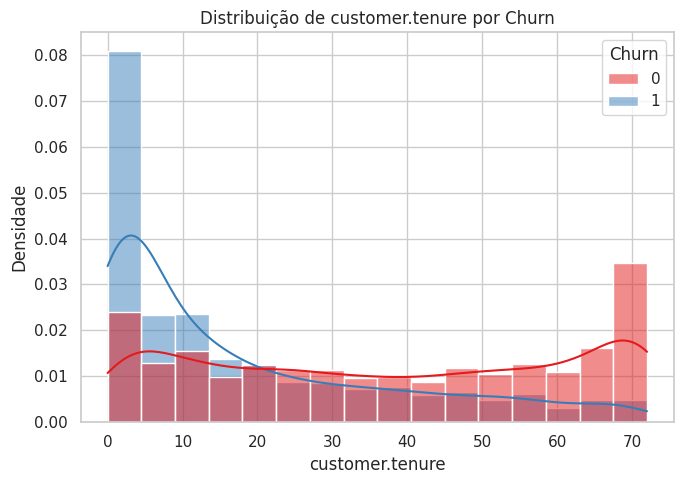

In [53]:
plot_dist_by_churn('customer.tenure', df)

#📄Relatorio Final


 ### Distribuição geral de Churn
Foi observado que aproximadamente 26,5% dos clientes cancelaram o serviço, enquanto 73,5% permaneceram.

###Churn por Variáveis Categóricas
Utilizando gráficos de barras empilhadas e pizza, analisamos a proporção de churn em diferentes perfis de clientes:

 ### Tipo de Contrato
Contratos mensais apresentaram a maior taxa de evasão.

Clientes com contratos de 1 ou 2 anos mostraram maior fidelidade.

 ### Método de Pagamento
Clientes que usam "Electronic Check"  tiveram maior churn.

Métodos automáticos como cartão de crédito e transferência bancária mostraram menores taxas.

 ### Dependentes e Parceiros
Clientes sem dependentes ou parceiros apresentaram maior tendência ao churn.

### Gênero
A diferença entre homens e mulheres foi mínima, sem viés significativo.

## Churn por Variáveis Numéricas
Foram analisadas variáveis contínuas como:

customer.tenure (tempo de contrato)

account.Charges.Total (gasto total do cliente)

account.Charges.Monthly (mensalidade)

account.Charges.Daily (gasto diário de cada cliente)



## Principais padrões encontrados:
Clientes que cancelaram tinham, em média, tempo de contrato menor.

O gasto total era visivelmente mais baixo entre churners, indicando que muitos cancelaram logo após entrar.

Em alguns casos, a mensalidade média era maior entre quem saiu = possível insatisfação com o custo.

## Conclusões e Insights
A maior parte dos cancelamentos está relacionada a clientes com contrato mensal, sem dependentes, e com pouco tempo de casa.

Métodos de pagamento manuais (ex: cheque eletrônico) estão fortemente associados ao churn.

Clientes com maior gasto total e mais tempo de contrato têm menor propensão a cancelar.

Esses padrões indicam que clientes mais novos, com menos vínculos e pagando manualmente são os mais vulneráveis à evasão.

## Recomendações Estratégicas
Com base na análise, recomenda-se:

Programas de fidelidade ou benefícios para novos clientes nos primeiros meses (reduzir churn precoce).

Incentivar contratos mais longos com descontos ou bônus.

Promover pagamento automático com incentivos (cashback, bônus, etc.).

Oferecer atendimento personalizado para clientes de perfil mais propenso a churn (ex: contrato mensal + sem dependentes).

Monitorar clientes com alta mensalidade e pouco tempo de contrato, pois podem ser os mais insatisfeitos.


